In [1]:
import re
import time
import math
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import GridSearchCV

from sklearn import tree
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

In [2]:
# Replace the path with the correct path for your data.
occupied = pd.read_csv('C:/Users/keith/Desktop/Thinkful/datatest.txt',encoding = "ISO-8859-1")

pd.set_option('display.max_columns', None) # disables trucated columns 
pd.set_option('display.max_rows', None) # disables trucated rows


### Predict if a room is occupied or not

In [3]:
occupied.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [4]:
occupied.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2665 entries, 140 to 2804
Data columns (total 7 columns):
date             2665 non-null object
Temperature      2665 non-null float64
Humidity         2665 non-null float64
Light            2665 non-null float64
CO2              2665 non-null float64
HumidityRatio    2665 non-null float64
Occupancy        2665 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 166.6+ KB


In [5]:
occupied.Occupancy.value_counts()

0    1693
1     972
Name: Occupancy, dtype: int64

In [6]:
print(len(occupied))
print(occupied.isnull().values.any())

2665
False


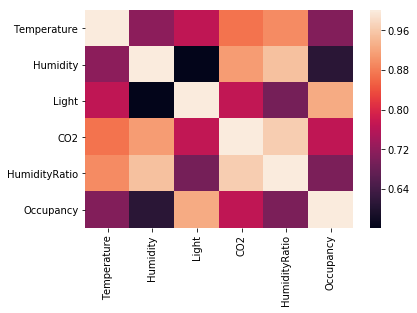

In [7]:
sns.heatmap(occupied.corr())

## Decision Tree

In [8]:
occupied.columns

Index(['date', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio',
       'Occupancy'],
      dtype='object')

In [9]:
X = occupied.drop(['Occupancy','date'],1) 
Y = occupied['Occupancy']

In [10]:
scaled_data = preprocessing.scale(X)
pca = PCA() # create a PCA object
pca.fit(scaled_data) # do the math
pca_data = pca.transform(scaled_data)

In [11]:
pca_data.shape

(2665, 5)

In [12]:
start_time = time.time() # start timer fff

# Initialize and train decision tree.
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', max_features= 'sqrt', max_depth=8,random_state=20)

decision_tree.fit(pca_data, Y)
print(cross_val_score(decision_tree, pca_data, Y, cv=5))
print()
print("--- %s seconds ---" % (time.time() - start_time)) # end timer

[0.53370787 0.8071161  0.73733583 1.         0.90789474]

--- 0.026927709579467773 seconds ---


In [13]:
from sklearn.model_selection import train_test_split

# train_test_split to create the necessary training and test groups

X_train, X_test, y_train, y_test = train_test_split(pca_data, Y, test_size=.25, random_state=20)
print('With 25% Holdout: ' + str(decision_tree.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(decision_tree.fit(pca_data, Y).score(pca_data, Y)))

y_pred =  decision_tree.predict(pca_data)


With 25% Holdout: 0.9805097451274363
Testing on Sample: 0.9921200750469044


In [14]:
# import and impliment comfusion matrix

from sklearn.metrics import confusion_matrix
conf = confusion_matrix(Y,y_pred)

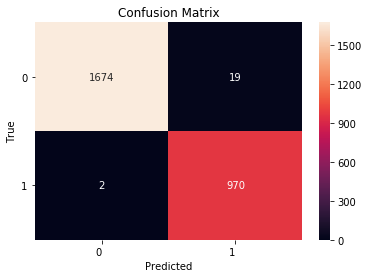

In [15]:
# plot confusion matrix

heatmap = sns.heatmap(conf, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right')
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [16]:
# Classification report
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(Y, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       1.00      0.99      0.99      1693
     class 1       0.98      1.00      0.99       972

   micro avg       0.99      0.99      0.99      2665
   macro avg       0.99      0.99      0.99      2665
weighted avg       0.99      0.99      0.99      2665



In [17]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(decision_tree.get_params())

Parameters currently in use:

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 20,
 'splitter': 'best'}


In [18]:
param_grid = dict(max_depth=range(1,5),max_leaf_nodes=range(2,10),max_features=range(1,5))

In [19]:
grid = GridSearchCV(decision_tree, param_grid, cv=10, scoring="accuracy", return_train_score=True)

In [20]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=20,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(1, 5), 'max_leaf_nodes': range(2, 10), 'max_features': range(1, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [21]:
GScv_results = pd.DataFrame(grid.cv_results_)
GScv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.001297,4.570417e-04,0.000199,0.000398,1,1,2,"{'max_depth': 1, 'max_features': 1, 'max_leaf_...",0.825,0.805,0.845,0.820,0.835,0.825,0.825,0.830,0.834171,0.819095,0.826326,0.010256,103,0.826474,0.828699,0.824249,0.827030,0.825362,0.826474,0.826474,0.825918,0.825459,0.827126,0.826326,0.001140
1,0.001097,2.991679e-04,0.000200,0.000399,1,1,3,"{'max_depth': 1, 'max_features': 1, 'max_leaf_...",0.825,0.805,0.845,0.820,0.835,0.825,0.825,0.830,0.834171,0.819095,0.826326,0.010256,103,0.826474,0.828699,0.824249,0.827030,0.825362,0.826474,0.826474,0.825918,0.825459,0.827126,0.826326,0.001140
2,0.000997,4.891940e-07,0.000200,0.000399,1,1,4,"{'max_depth': 1, 'max_features': 1, 'max_leaf_...",0.825,0.805,0.845,0.820,0.835,0.825,0.825,0.830,0.834171,0.819095,0.826326,0.010256,103,0.826474,0.828699,0.824249,0.827030,0.825362,0.826474,0.826474,0.825918,0.825459,0.827126,0.826326,0.001140
3,0.000997,4.891940e-07,0.000399,0.000489,1,1,5,"{'max_depth': 1, 'max_features': 1, 'max_leaf_...",0.825,0.805,0.845,0.820,0.835,0.825,0.825,0.830,0.834171,0.819095,0.826326,0.010256,103,0.826474,0.828699,0.824249,0.827030,0.825362,0.826474,0.826474,0.825918,0.825459,0.827126,0.826326,0.001140
4,0.000998,4.702349e-07,0.000199,0.000399,1,1,6,"{'max_depth': 1, 'max_features': 1, 'max_leaf_...",0.825,0.805,0.845,0.820,0.835,0.825,0.825,0.830,0.834171,0.819095,0.826326,0.010256,103,0.826474,0.828699,0.824249,0.827030,0.825362,0.826474,0.826474,0.825918,0.825459,0.827126,0.826326,0.001140
5,0.001001,1.016167e-05,0.000398,0.000488,1,1,7,"{'max_depth': 1, 'max_features': 1, 'max_leaf_...",0.825,0.805,0.845,0.820,0.835,0.825,0.825,0.830,0.834171,0.819095,0.826326,0.010256,103,0.826474,0.828699,0.824249,0.827030,0.825362,0.826474,0.826474,0.825918,0.825459,0.827126,0.826326,0.001140
6,0.000998,4.104748e-06,0.000199,0.000398,1,1,8,"{'max_depth': 1, 'max_features': 1, 'max_leaf_...",0.825,0.805,0.845,0.820,0.835,0.825,0.825,0.830,0.834171,0.819095,0.826326,0.010256,103,0.826474,0.828699,0.824249,0.827030,0.825362,0.826474,0.826474,0.825918,0.825459,0.827126,0.826326,0.001140
7,0.001100,2.978411e-04,0.000395,0.000484,1,1,9,"{'max_depth': 1, 'max_features': 1, 'max_leaf_...",0.825,0.805,0.845,0.820,0.835,0.825,0.825,0.830,0.834171,0.819095,0.826326,0.010256,103,0.826474,0.828699,0.824249,0.827030,0.825362,0.826474,0.826474,0.825918,0.825459,0.827126,0.826326,0.001140
8,0.001496,4.917179e-04,0.000399,0.000488,1,2,2,"{'max_depth': 1, 'max_features': 2, 'max_leaf_...",0.825,0.805,0.845,0.820,0.835,0.825,0.825,0.830,0.834171,0.819095,0.826326,0.010256,103,0.826474,0.828699,0.824249,0.827030,0.825362,0.826474,0.826474,0.825918,0.825459,0.827126,0.826326,0.001140
9,0.001695,4.584413e-04,0.000100,0.000299,1,2,3,"{'max_depth': 1, 'max_features': 2, 'max_leaf_...",0.955,0.915,0.920,0.965,0.950,0.950,0.940,0.920,0.954774,0.914573,0.938438,0.018206,55,0.938265,0.942714,0.949388,0.943826,0.938821,0.938821,0.939377,0.942158,0.938299,0.942746,0.941442,0.003326


## Random Forrest

In [22]:
X = occupied.drop(['Occupancy','date','Temperature', 'Humidity','HumidityRatio'],1)
X = pd.get_dummies(X)
Y = occupied['Occupancy']

In [23]:
start_time = time.time() # start timer
rfc = ensemble.RandomForestClassifier(criterion='entropy',random_state=20, max_features='sqrt') 
rfc.fit(X,Y)

print(cross_val_score(rfc, X, Y, cv=5))
print()
print("--- %s seconds ---" % (time.time() - start_time)) # end timer

[0.95692884 0.95131086 0.92870544 1.         0.95864662]

--- 0.09574484825134277 seconds ---


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [24]:
from sklearn.model_selection import train_test_split
#Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.25, random_state=20)
print('With 25% Holdout: ' + str(rfc.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(rfc.fit(X, Y).score(X, Y)))

With 25% Holdout: 0.9865067466266867
Testing on Sample: 0.999249530956848


In [25]:
# Classification report

target_names = ['class 0', 'class 1']
print(classification_report(Y, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       1.00      0.99      0.99      1693
     class 1       0.98      1.00      0.99       972

   micro avg       0.99      0.99      0.99      2665
   macro avg       0.99      0.99      0.99      2665
weighted avg       0.99      0.99      0.99      2665



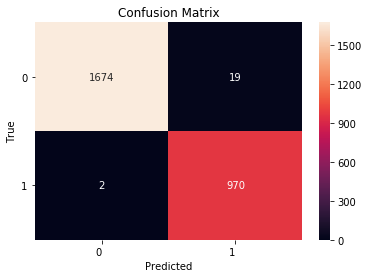

In [26]:
# plot confusion matrix 

conf = confusion_matrix(Y,y_pred)

heatmap = sns.heatmap(conf, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right')
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [27]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 20,
 'verbose': 0,
 'warm_start': False}


In [28]:
param_grid = dict(max_depth=range(1,5),min_samples_leaf=range(1,3),n_estimators=range(1,10))

In [29]:
grid = GridSearchCV(rfc, param_grid, cv=10, scoring="accuracy",return_train_score=True)

In [30]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=20, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(1, 5), 'min_samples_leaf': range(1, 3), 'n_estimators': range(1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [31]:
# Gridsearchcv rel
GScv_results = pd.DataFrame(grid.cv_results_)
GScv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.002494,8.040876e-04,0.000897,2.989036e-04,1,1,1,"{'max_depth': 1, 'min_samples_leaf': 1, 'n_est...",0.985,0.955,0.985,0.995,0.985,0.985,0.985,0.960,0.984925,0.959799,0.977978,0.013289,16,0.977197,0.980534,0.977197,0.976085,0.977197,0.977197,0.977197,0.979978,0.977210,0.979989,0.977978,0.001477
1,0.002992,4.891940e-07,0.000698,4.569914e-04,1,1,2,"{'max_depth': 1, 'min_samples_leaf': 1, 'n_est...",0.985,0.955,0.985,0.995,0.985,0.985,0.985,0.960,0.984925,0.959799,0.977978,0.013289,16,0.977197,0.980534,0.977197,0.976085,0.977197,0.977197,0.977197,0.979978,0.977210,0.979989,0.977978,0.001477
2,0.003690,4.569500e-04,0.000898,2.992082e-04,1,1,3,"{'max_depth': 1, 'min_samples_leaf': 1, 'n_est...",0.985,0.955,0.985,0.995,0.985,0.985,0.985,0.960,0.984925,0.959799,0.977978,0.013289,16,0.977197,0.980534,0.977197,0.976085,0.977197,0.977197,0.977197,0.979978,0.977210,0.979989,0.977978,0.001477
3,0.004188,5.977834e-04,0.000998,4.774328e-07,1,1,4,"{'max_depth': 1, 'min_samples_leaf': 1, 'n_est...",0.985,0.955,0.985,0.995,0.985,0.985,0.985,0.960,0.984925,0.959799,0.977978,0.013289,16,0.977197,0.980534,0.977197,0.976085,0.977197,0.977197,0.977197,0.979978,0.977210,0.979989,0.977978,0.001477
4,0.004787,3.989990e-04,0.001194,3.920286e-04,1,1,5,"{'max_depth': 1, 'min_samples_leaf': 1, 'n_est...",0.985,0.955,0.985,0.995,0.985,0.985,0.985,0.960,0.984925,0.959799,0.977978,0.013289,16,0.977197,0.980534,0.977197,0.976085,0.977197,0.977197,0.977197,0.979978,0.977210,0.979989,0.977978,0.001477
5,0.005186,3.992863e-04,0.001197,3.996573e-04,1,1,6,"{'max_depth': 1, 'min_samples_leaf': 1, 'n_est...",0.985,0.955,0.985,0.995,0.985,0.985,0.985,0.960,0.984925,0.959799,0.977978,0.013289,16,0.977197,0.980534,0.977197,0.976085,0.977197,0.977197,0.977197,0.979978,0.977210,0.979989,0.977978,0.001477
6,0.006183,4.078306e-04,0.001297,4.571590e-04,1,1,7,"{'max_depth': 1, 'min_samples_leaf': 1, 'n_est...",0.985,0.955,0.985,0.995,0.985,0.985,0.985,0.960,0.984925,0.959799,0.977978,0.013289,16,0.977197,0.980534,0.977197,0.976085,0.977197,0.977197,0.977197,0.979978,0.977210,0.979989,0.977978,0.001477
7,0.006785,4.005093e-04,0.001390,4.792315e-04,1,1,8,"{'max_depth': 1, 'min_samples_leaf': 1, 'n_est...",0.985,0.955,0.985,0.995,0.985,0.985,0.985,0.960,0.984925,0.959799,0.977978,0.013289,16,0.977197,0.980534,0.977197,0.976085,0.977197,0.977197,0.977197,0.979978,0.977210,0.979989,0.977978,0.001477
8,0.007380,4.889914e-04,0.001500,5.022571e-04,1,1,9,"{'max_depth': 1, 'min_samples_leaf': 1, 'n_est...",0.985,0.955,0.985,0.995,0.985,0.985,0.985,0.960,0.984925,0.959799,0.977978,0.013289,16,0.977197,0.980534,0.977197,0.976085,0.977197,0.977197,0.977197,0.979978,0.977210,0.979989,0.977978,0.001477
9,0.002092,2.891371e-04,0.000897,2.990983e-04,1,2,1,"{'max_depth': 1, 'min_samples_leaf': 2, 'n_est...",0.985,0.955,0.985,0.995,0.985,0.985,0.985,0.960,0.984925,0.959799,0.977978,0.013289,16,0.977197,0.980534,0.977197,0.976085,0.977197,0.977197,0.977197,0.979978,0.977210,0.979989,0.977978,0.001477
